<a href="https://colab.research.google.com/github/hasrhamathew/Sentiment_analysis/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Mounting Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/reviews.xlsx'  # Replace with your actual file path
df = pd.read_excel(file_path)

# Display the first few rows of the dataset
print(df.head())

   Unnamed: 0   Airline Name Overall_Rating  \
0           0    AB Aviation              9   
1           1    AB Aviation              1   
2           2    AB Aviation              1   
3           3  Adria Airways              1   
4           4  Adria Airways              1   

                            Review_Title          Review Date  Verified  \
0                "pretty decent airline"   11th November 2019      True   
1                   "Not a good airline"       25th June 2019      True   
2         "flight was fortunately short"       25th June 2019      True   
3    "I will never fly again with Adria"  28th September 2019     False   
4  "it ruined our last days of holidays"  24th September 2019      True   

                                              Review       Aircraft  \
0    Moroni to Moheli. Turned out to be a pretty ...            NaN   
1   Moroni to Anjouan. It is a very small airline...           E120   
2    Anjouan to Dzaoudzi. A very small airline an... 

In [ ]:
# Cleaning the dataset
# Check for missing values
print(df.isnull().sum())

Unnamed: 0                    0
Airline Name                  0
Overall_Rating                0
Review_Title                  0
Review Date                   0
Verified                      0
Review                        0
Aircraft                  16042
Type Of Traveller          3738
Seat Type                  1096
Route                      3828
Date Flown                 3754
Seat Comfort               4155
Cabin Staff Service        4260
Food & Beverages           8671
Ground Service             4793
Inflight Entertainment    12342
Wifi & Connectivity       17251
Value For Money            1066
Recommended                   0
dtype: int64


In [ ]:
# Check for missing values
df.isnull().sum()

# Drop rows with missing values
df.dropna(subset=['Review'], inplace=True)


In [ ]:
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply the cleaning function to the review column
df['cleaned_review'] = df['Review'].apply(clean_text)

# Display the cleaned text
df[['Review', 'cleaned_review']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Review,cleaned_review
5,Had very bad experience with rerouted and ca...,bad experience rerouted cancelled flights last...
7,"First of all, I am not complaining about a s...",first complaining specific flight lufthansa fr...
22,Ljubljana to Vienna. After a fast boarding p...,ljubljana vienna fast boarding procedure plane...
29,Booked this flight after many years using Easy...,booked flight many years using easyjet got fli...
113,Aegean Airlines will remain always my first ...,aegean airlines remain always first choice fav...


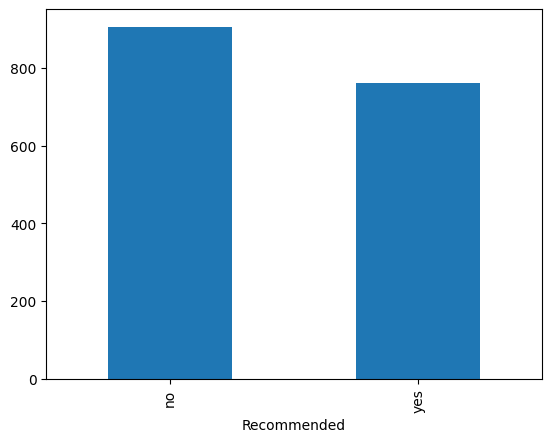

In [ ]:
# Basic statistics
df.describe()

# Count of reviews per sentiment (if applicable)
if 'Recommended' in df.columns:
    df['Recommended'].value_counts().plot(kind='bar')



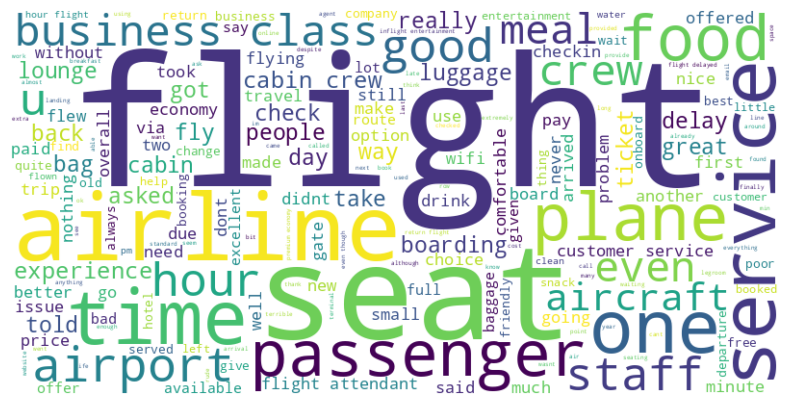

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['cleaned_review']))

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



In [ ]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

# Apply the lemmatization function
df['lemmatized_review'] = df['cleaned_review'].apply(lemmatize_text)

# Display the lemmatized text
df[['cleaned_review', 'lemmatized_review']].head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,cleaned_review,lemmatized_review
5,bad experience rerouted cancelled flights last...,bad experience rerouted cancelled flight last ...
7,first complaining specific flight lufthansa fr...,first complaining specific flight lufthansa fr...
22,ljubljana vienna fast boarding procedure plane...,ljubljana vienna fast boarding procedure plane...
29,booked flight many years using easyjet got fli...,booked flight many year using easyjet got flig...
113,aegean airlines remain always first choice fav...,aegean airline remain always first choice favo...


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
text_matrix = vectorizer.fit_transform(df['lemmatized_review'])

# Apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(text_matrix)

# Display the top words in each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)


Topic 0:
seat flight class food good service crew business cabin airline
Topic 1:
flight hour airline time airport day bag passenger told customer
Topic 2:
flight seat crew plane service hour passenger asked time cabin
Topic 3:
airline flight service hour staff time luggage experience worst food
Topic 4:
flight seat good service crew food time staff great meal


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'Recommended' is the target variable for sentiment (1 for positive, 0 for negative)
X = df['lemmatized_review']
y = df['Recommended']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Create a pipeline
model = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.9, min_df=2, stop_words='english')),
    ('clf', LogisticRegression())
])

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Accuracy: 0.8592814371257484
              precision    recall  f1-score   support

          no       0.89      0.88      0.88       201
         yes       0.82      0.83      0.82       133

    accuracy                           0.86       334
   macro avg       0.85      0.85      0.85       334
weighted avg       0.86      0.86      0.86       334

